# Compare to mouse

Hochgerner et al., 2018

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE104323

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp
import seaborn as sns

sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.cachedir = '/ssd/rulands/fabian_tmp/cache/'

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.4 scipy==1.3.1 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
require(ggplot2)
require(ggalluvial)
require(magrittr)
require(RColorBrewer)
require(viridis)
require(ggsci)

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: ggalluvial

R[write to console]: Loading required package: magrittr

R[write to console]: Loading required package: RColorBrewer

R[write to console]: Loading required package: viridis

R[write to console]: Loading required package: viridisLite

R[write to console]: Loading required package: ggsci



## Read data

### Hochgerner, 2018

In [4]:
adata_hochgerner = sc.read('/scratch/rulands/zebrafish_brain_christian_lange/GSE104323/GSE104323_10X_expression_data_V2.tab', cache=True).T

... reading from cache file /ssd/rulands/fabian_tmp/cache/scratch-rulands-zebrafish_brain_christian_lange-GSE104323-GSE104323_10X_expression_data_V2.h5ad


In [5]:
obs = pd.read_csv('/scratch/rulands/zebrafish_brain_christian_lange/GSE104323/GSE104323_metadata_barcodes_24185cells.txt', sep='\t')

In [6]:
obs.index = obs['Sample name (24185 single cells)']

In [7]:
adata_hochgerner.obs = obs.loc[adata_hochgerner.obs_names]

In [8]:
adata_hochgerner.obs['cluster'] = adata_hochgerner.obs['characteristics: cell cluster']

In [9]:
adata_hochgerner.obs['cluster'] = adata_hochgerner.obs['cluster'].replace('MiCajal-Retziusoglia', 'Microglia')

### Lange

In [10]:
adata_zebrafish = sc.read('./zebrafish_neurogenesis_smartseq.h5ad')

In [11]:
adata_zebrafish.obs = adata_zebrafish.obs.rename(columns={'cell.type': 'sort_gate'})

In [12]:
adata_zebrafish.var_names = list(adata_zebrafish.var['Symbol'])

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [13]:
adata_zebrafish.var_names_make_unique()

In [14]:
adata_zebrafish = adata_zebrafish[:, ~adata_zebrafish.var['is_feature_control_ERCC']]

In [15]:
adata_zebrafish.var_names = adata_zebrafish.var['ID']

In [16]:
adata_zebrafish.obs['sort_gate'].cat.rename_categories(['NBN', 'MN', 'RG'], inplace=True)

In [17]:
adata_zebrafish.obs['sort_gate'].cat.reorder_categories(['RG', 'NBN', 'MN'], inplace=True)

In [18]:
cluster_obs = sc.read('../../../results/zebrafish_neurogenesis_smartseq_processed.h5ad').obs

adata_zebrafish.obs['cluster'] = cluster_obs.loc[adata_zebrafish.obs_names, 'louvain']

/home/fabrost/miniconda3/envs/spols190426/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
Trying to set attribute `.obs` of view, making a copy.


### Marker gene list

In [19]:
marker_genes = (pd.read_excel('/home/fabrost/pksCloud/projects/zebrafish_neurogenesis_smartseq/data/orthologs_mouse/190819_gene list zf mouse comparison_OPC.xlsx',
                              header=[0,1])
                .replace('no homolog')
                .dropna(axis='columns', how='all')
                .swaplevel(axis='columns')['mouse'].unstack().dropna()
                .groupby(level=0).apply(lambda group: group.drop_duplicates())
               )

print('Did not find the following genes in adata.var_names:\n')
print(marker_genes[~marker_genes.isin(adata_hochgerner.var_names)])
print('\nExcluding them from analysis.')
marker_genes = marker_genes[marker_genes.isin(adata_hochgerner.var_names)]

Did not find the following genes in adata.var_names:

RG  RG  17    Hes4
dtype: object

Excluding them from analysis.


## Orthologs

http://www.ensembl.org/biomart/martview/d81b6aef15e4e70f94d34db8b8f23110?VIRTUALSCHEMANAME=default&ATTRIBUTES=drerio_gene_ensembl.default.homologs.ensembl_gene_id|drerio_gene_ensembl.default.homologs.external_gene_name|drerio_gene_ensembl.default.homologs.mmusculus_homolog_ensembl_gene|drerio_gene_ensembl.default.homologs.mmusculus_homolog_associated_gene_name&FILTERS=drerio_gene_ensembl.default.filters.with_mmusculus_homolog.only&VISIBLEPANEL=attributepanel

In [20]:
ortho = pd.read_csv('./mart_export.txt', skiprows=1)

In [21]:
ortho = ortho[ortho['Mouse gene name'].isin(adata_hochgerner.var_names)]

In [22]:
ortho = ortho[ortho['Gene stable ID'].isin(adata_zebrafish.var_names)]

In [23]:
ortho.head(10)

,Gene stable ID,Gene name,Mouse gene stable ID,Mouse gene name
0,ENSDARG00000063344,fam162a,ENSMUSG00000003955,Fam162a
1,ENSDARG00000036008,caly,ENSMUSG00000025468,Caly
2,ENSDARG00000069301,tmem177,ENSMUSG00000036975,Tmem177
3,ENSDARG00000104901,ostc,ENSMUSG00000041084,Ostc
4,ENSDARG00000031836,vps37c,ENSMUSG00000048832,Vps37c
5,ENSDARG00000103391,rab9b,ENSMUSG00000043463,Rab9b
6,ENSDARG00000030463,tppp3,ENSMUSG00000014846,Tppp3
7,ENSDARG00000070447,slc39a9,ENSMUSG00000048833,Slc39a9
8,ENSDARG00000036109,mtx1b,ENSMUSG00000064068,Mtx1
9,ENSDARG00000029612,gpkow,ENSMUSG00000031148,Gpkow


In [24]:
ortho[ortho['Mouse gene stable ID'].duplicated(keep=False)].sort_values('Mouse gene stable ID').head()

,Gene stable ID,Gene name,Mouse gene stable ID,Mouse gene name
3963,ENSDARG00000088383,cox5aa,ENSMUSG00000000088,Cox5a
25511,ENSDARG00000099663,cox5ab,ENSMUSG00000000088,Cox5a
5304,ENSDARG00000006120,tbx2b,ENSMUSG00000000093,Tbx2
17979,ENSDARG00000018025,tbx2a,ENSMUSG00000000093,Tbx2
24834,ENSDARG00000098424,CABZ01079241.1,ENSMUSG00000000103,Zfy2


In [25]:
ortho_bijective = ortho[~(ortho['Gene stable ID'].duplicated() | ortho['Mouse gene stable ID'].duplicated())]
ortho_bijective = ortho_bijective[~ortho_bijective['Mouse gene name'].duplicated(False)]

In [26]:
marker_genes[~marker_genes.isin(ortho_bijective['Mouse gene name'])]

MN     MN     6        Aldoa
              15      Ppp3cb
              27      Rnasek
NBN.1  NBN.1  3     Ppp1r14b
              5       Tmsb4x
              11     Hnrnpa0
              15         Hn1
NBN.2  NBN.2  6         Etv5
              9         Cdh8
              16      Pcp4l1
              19      Ptprn2
              24      Hspa1l
OPC    OPC    2        Cd59b
              13    Tmem178b
RG     RG     19       Sepp1
              22       Fads2
              23       Efhd1
dtype: object

In [27]:
marker_genes[~marker_genes.isin(ortho['Mouse gene name'])]

MN     MN     15      Ppp3cb
NBN.1  NBN.1  5       Tmsb4x
              11     Hnrnpa0
              15         Hn1
NBN.2  NBN.2  6         Etv5
              9         Cdh8
              16      Pcp4l1
              19      Ptprn2
              24      Hspa1l
OPC    OPC    2        Cd59b
              13    Tmem178b
RG     RG     19       Sepp1
              22       Fads2
              23       Efhd1
dtype: object

## QC

### Hochgerner

In [28]:
sc.pp.filter_cells(adata_hochgerner, min_genes=200)
# sc.pp.filter_genes(adata, min_cells=3)

In [29]:
sc.pp.calculate_qc_metrics(adata_hochgerner, inplace=True)

... storing 'source name' as categorical
... storing 'organism' as categorical
... storing 'characteristics: strain' as categorical
... storing 'characteristics: age' as categorical
... storing 'characteristics: sex of pooled animals' as categorical
... storing 'characteristics: cell cluster' as categorical
... storing 'molecule' as categorical
... storing 'cluster' as categorical


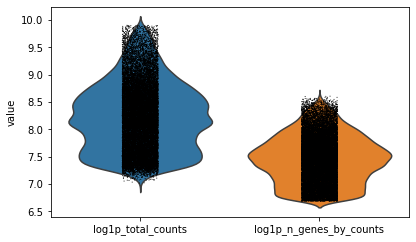

In [30]:
sc.pl.violin(adata_hochgerner, ['log1p_total_counts', 'log1p_n_genes_by_counts'])

### lange

In [31]:
min_log10_counts = 4.5
min_log10_features = 2.7
max_log10_features = 3.9
max_Mito = 20
max_ERCC=25
min_mapped = 0.2
max_pct_counts_top50 = 50

n_cells0 = adata_zebrafish.n_obs

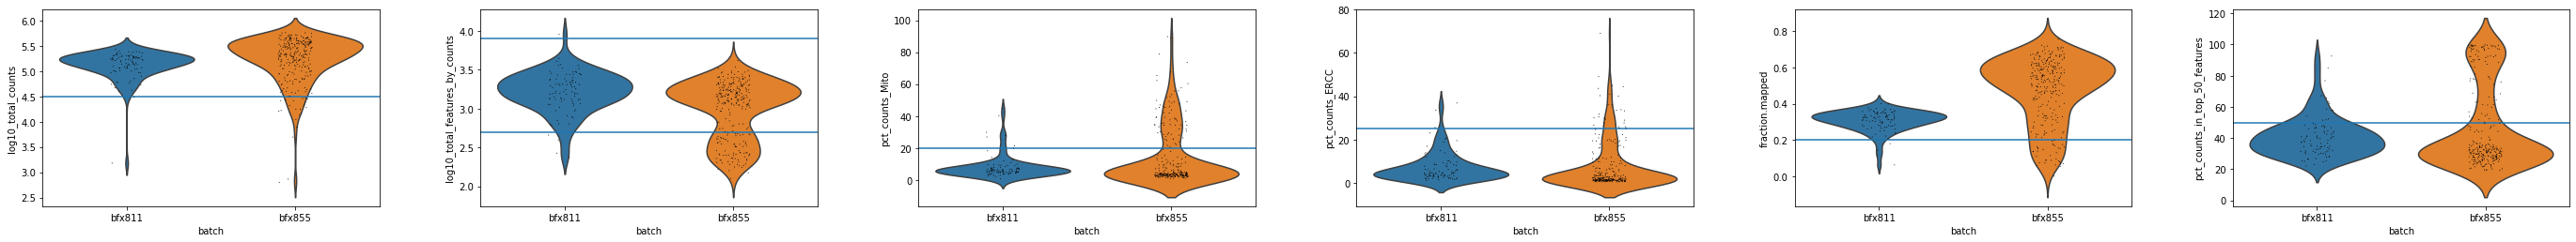

In [32]:
axs = sc.pl.violin(adata_zebrafish, 
             ['log10_total_counts', 'log10_total_features_by_counts', 'pct_counts_Mito',
              'pct_counts_ERCC', 'fraction.mapped', 'pct_counts_in_top_50_features'], 
             groupby='batch', show=False)
axs[0].axhline(min_log10_counts)
axs[1].axhline(min_log10_features)
axs[1].axhline(max_log10_features)
axs[2].axhline(max_Mito)
axs[3].axhline(max_ERCC)
axs[4].axhline(min_mapped)
axs[5].axhline(max_pct_counts_top50)
plt.show()

In [33]:
adata_zebrafish = adata_zebrafish[adata_zebrafish.obs['log10_total_counts'] > min_log10_counts]
adata_zebrafish = adata_zebrafish[adata_zebrafish.obs['log10_total_features_by_counts'] > min_log10_features]
adata_zebrafish = adata_zebrafish[adata_zebrafish.obs['log10_total_features_by_counts'] < max_log10_features]
adata_zebrafish = adata_zebrafish[adata_zebrafish.obs['pct_counts_Mito'] < max_Mito]
adata_zebrafish = adata_zebrafish[adata_zebrafish.obs['pct_counts_ERCC'] < max_ERCC]
adata_zebrafish = adata_zebrafish[adata_zebrafish.obs['fraction.mapped'] > min_mapped]
adata_zebrafish = adata_zebrafish[adata_zebrafish.obs['pct_counts_in_top_50_features'] < max_pct_counts_top50]
print(f'Filtered {n_cells0 - adata_zebrafish.n_obs} cells. Remaining cells: {adata_zebrafish.n_obs}')

Filtered 106 cells. Remaining cells: 264


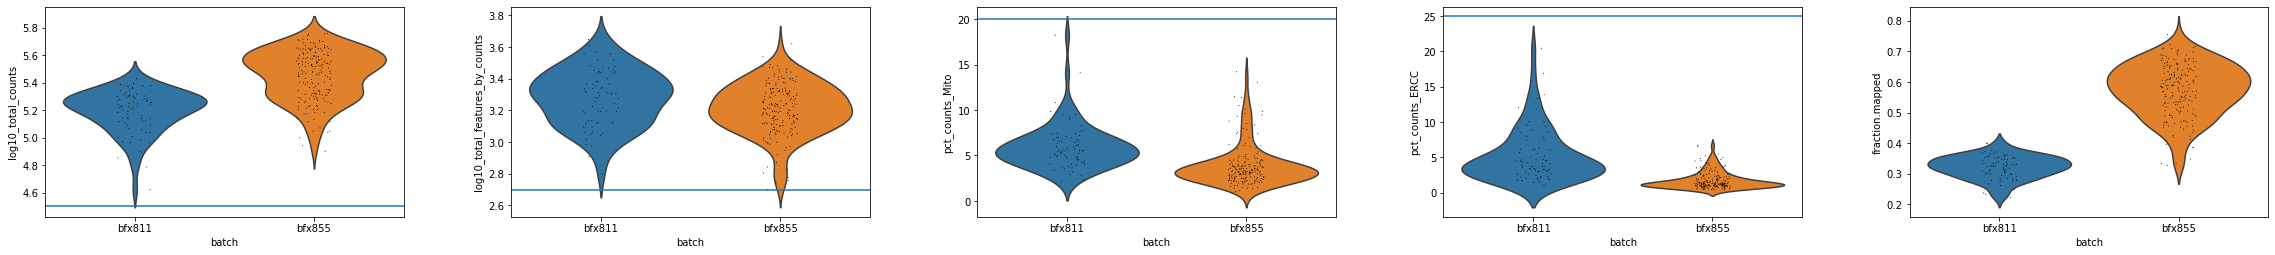

In [34]:
axs = sc.pl.violin(adata_zebrafish, 
             ['log10_total_counts', 'log10_total_features_by_counts', 
              'pct_counts_Mito', 'pct_counts_ERCC', 'fraction.mapped'], 
             groupby='batch', show=False)
axs[0].axhline(min_log10_counts)
axs[1].axhline(min_log10_features)
axs[2].axhline(max_Mito)
axs[3].axhline(max_ERCC)
plt.show()

## Normalise

### Hochgerner

In [35]:
sc.pp.normalize_per_cell(adata_hochgerner)

normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [36]:
sc.pp.log1p(adata_hochgerner)

In [37]:
adata_hochgerner.raw = adata_hochgerner

### Lange

In [38]:
sc.pp.normalize_per_cell(adata_zebrafish)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [39]:
sc.pp.log1p(adata_zebrafish)

In [40]:
adata_zebrafish.raw = adata_zebrafish

## Redefine X on metagenes

### Hochgerner data

In [41]:
X_hochgerner = adata_hochgerner[:, ortho['Mouse gene name']].X

In [42]:
adata_hochgerner_meta = sc.AnnData(X_hochgerner, obs=adata_hochgerner.obs, var=ortho)

Transforming to str index.


### Lange data

In [43]:
X_zebrafish = adata_zebrafish[:, ortho['Gene stable ID']].X.toarray()

In [44]:
adata_zebrafish_meta = sc.AnnData(X_zebrafish, obs=adata_zebrafish.obs, var=ortho)

Transforming to str index.


In [45]:
adata_zebrafish_meta.rename_categories('cluster', ['RG', 'NBN1', 'NBN2', 'MN', 'OPC_Z'])

## merge data

In [46]:
adata = adata_hochgerner_meta.concatenate(adata_zebrafish_meta, batch_key='species', batch_categories=['mouse', 'zebrafish'])

## Combat

In [47]:
sc.pp.combat(adata, 'species')

... storing 'SRR run accession' as categorical
... storing 'Sample name (24185 single cells)' as categorical
... storing 'UMI_CellularBarcode' as categorical
... storing 'batch' as categorical
... storing 'characteristics: age' as categorical
... storing 'characteristics: cell cluster' as categorical
... storing 'characteristics: sex of pooled animals' as categorical
... storing 'characteristics: strain' as categorical
... storing 'cluster' as categorical
... storing 'file.name' as categorical
... storing 'fish.name' as categorical
... storing 'is.bulk' as categorical
... storing 'is.nc' as categorical
... storing 'is.rna' as categorical
... storing 'is_cell_control' as categorical
... storing 'molecule' as categorical
... storing 'organism' as categorical
... storing 'raw file (original file name)' as categorical
... storing 'sample_id' as categorical
... storing 'sort_gate' as categorical
... storing 'source name' as categorical
... storing 'Gene stable ID' as categorical
... storing

Standardizing Data across genes.

Found 2 batches

Found 0 numerical variables:
	

Found 1040 genes with zero variance.
Fitting L/S model and finding priors

Finding parametric adjustments



/home/fabrost/miniconda3/envs/spols190426/lib/python3.6/site-packages/scanpy/preprocessing/_combat.py:235: RuntimeWarning: invalid value encountered in true_divide
  b_prior[i],
/home/fabrost/miniconda3/envs/spols190426/lib/python3.6/site-packages/scanpy/preprocessing/_combat.py:235: RuntimeWarning: divide by zero encountered in true_divide
  b_prior[i],


Adjusting data



## Feature selection

In [48]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger')

extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


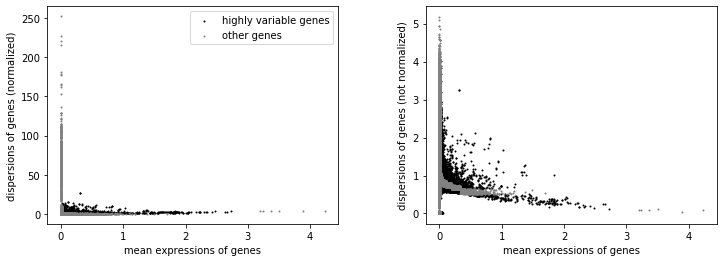

In [49]:
sc.pl.highly_variable_genes(adata)

## PCA

In [50]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:18)


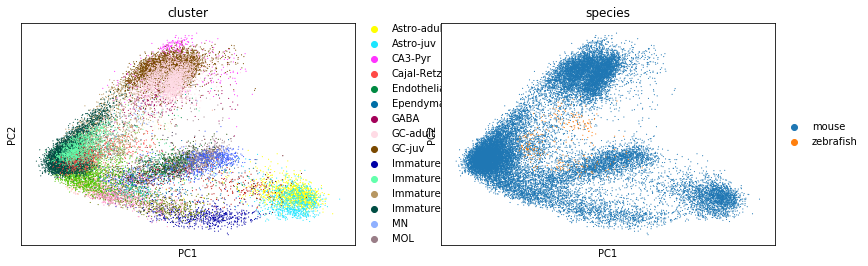

In [51]:
sc.pl.pca(adata, color=['cluster', 'species'])

## Dendrogram

In [52]:
sc.tl.dendrogram(adata, 'cluster', n_pcs=50)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cluster']`


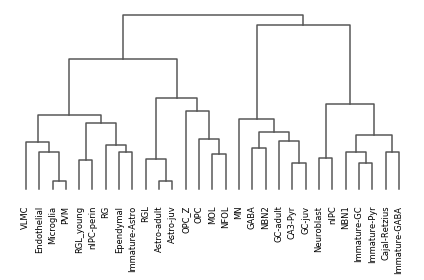

In [53]:
sc.pl.dendrogram(adata, 'cluster', show=False)
plt.tight_layout()
# plt.savefig('../../results/figures/hochgerner_dendrogram.pdf')
plt.show()

## Nearest neighbors

In [54]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [55]:
X = adata[adata.obs['species'] == 'mouse'].obsm['X_pca']

In [56]:
X_pca_zebrafish = adata[adata.obs['species'] == 'zebrafish'].obsm['X_pca']

In [57]:
nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute', metric='correlation').fit(X)
distances, indices = nbrs.kneighbors(X_pca_zebrafish)

In [78]:
adata_mouse = adata[adata.obs['species'] == 'mouse']
obs = adata[adata.obs['species'] == 'zebrafish'].obs[['cluster']]
obs['mouse cluster'] = adata_mouse.obs.iloc[indices[:,0]]['cluster'].values
obs['cluster'] = obs['cluster'].cat.reorder_categories(['RG', 'NBN1', 'NBN2', 'MN', 'OPC_Z'])
# obs['mouse cluster'] = obs['mouse cluster'].cat.reorder_categories([cat for cat in adata.uns['dendrogram_cluster']['dendrogram_info']['ivl'] 
#                                                     if cat in obs['mouse cluster'].cat.categories])
obs['mouse cluster'] = obs['mouse cluster'].cat.reorder_categories(['VLMC', 'Endothelial', 'Microglia', 'PVM', 
 'RGL_young', 'RGL', 
 'Immature-Astro',  'Astro-juv', 'Astro-adult',
 'nIPC-perin', 'Ependymal',  'OPC', 'MOL', 'NFOL', 'GABA', 'GC-adult', 'CA3-Pyr', 'GC-juv', 'Neuroblast', 'nIPC', 'Immature-GC', 'Immature-Pyr', 'Cajal-Retzius', 'Immature-GABA'])
obs['Nearest Neighbour Distance'] = distances

cat = obs['cluster'].cat.categories

In [79]:
threshold_distance = obs['Nearest Neighbour Distance'].quantile(0.66)

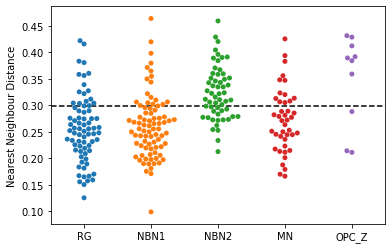

In [97]:
sns.swarmplot(data=obs, y='Nearest Neighbour Distance', x='cluster')
plt.axhline(threshold_distance, ls="--", color='k')
plt.xlabel('')
# plt.text(2., 0.45, 'a')
plt.savefig('../../../results/figures/hochgerner_distances.pdf')
plt.show()

In [61]:
# filter with fixed quantile threshold
obs = obs[obs['Nearest Neighbour Distance'] < threshold_distance]

In [62]:
knn = obs.groupby(['cluster', 'mouse cluster']).size().unstack().fillna(0).stack()
knn_matrix = knn.unstack().T.fillna(0)
knn = knn.reset_index()
knn.columns = ['zebrafish', 'mouse', 'cells']
# knn['zebrafish'] = knn['zebrafish'].cat.reorder_categories(["RG", "NBN1", "NBN2", "MN", "OPC_Z"])
# knn['mouse'] = knn['mouse'].cat.reorder_categories([cat for cat in adata.uns['dendrogram_cluster']['dendrogram_info']['ivl'] 
#                                                     if cat in knn['mouse'].cat.categories])

## Distance plot

In [63]:
# g = sns.catplot(data=obs, row='cluster', 
#             x='Nearest Neighbour Distance', y='mouse cluster',
#            kind='box', sharey=False)

In [64]:
distance_matrix = obs.groupby(['cluster', 'mouse cluster'])['Nearest Neighbour Distance'].median().unstack()

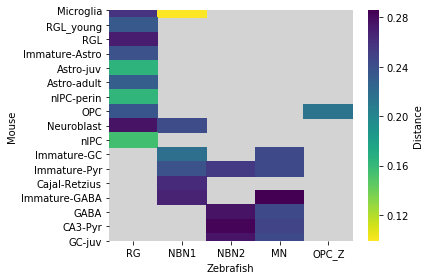

In [65]:
g = sns.heatmap(distance_matrix.T, cmap='viridis_r', cbar_kws={'label': 'Distance'})
g.set_facecolor('lightgrey')
plt.xlabel('Zebrafish')
plt.ylabel('Mouse')
plt.tight_layout()
plt.savefig('../../../results/figures/hochgerner_distance_matrix.pdf')
plt.show()

## Alluvium

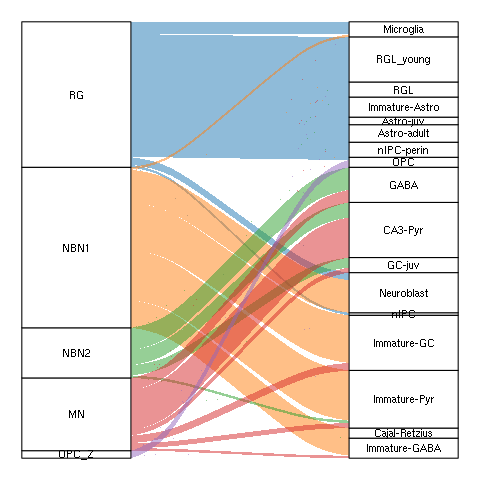

In [75]:
%%R -i knn

ggplot(knn, 
       aes(axis1 = zebrafish, axis2 = mouse, y = cells)) +
    geom_alluvium(aes(fill = zebrafish)) +
    geom_stratum() +
    geom_text(stat = "stratum", label.strata = TRUE, family="Helvetica") +
    scale_fill_manual(values=c('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd')) + 
    theme_void() + 
    theme(legend.position = "None") 

R[write to console]: Saving 6.67 x 6.67 in image



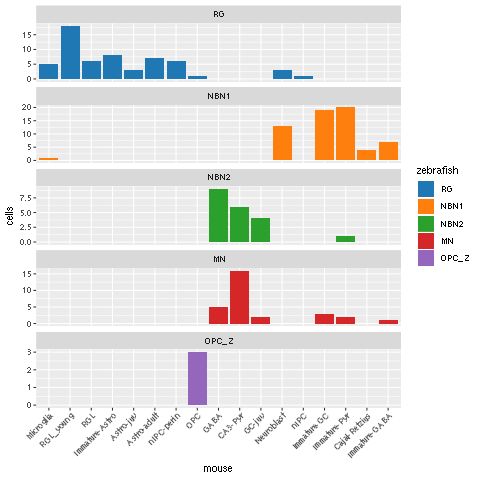

In [76]:
%%R
ggplot(knn, aes(x = mouse, y = cells, fill = zebrafish)) + 
    scale_fill_manual(values=c('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd')) + 
    geom_col(position = "dodge") + 
    facet_wrap(vars(zebrafish), ncol = 1, scale="free_y") +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    ggsave('../../../results/figures/cell_type_homology_bar.pdf')